<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению. Сессия № 3
Авторы материала: Юрий Кашницкий (@yorko) и Максим Уваров (@maxis42). Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

# <center>Домашнее задание № 3 
## <center> Деревья решений для классификации и регрессии

**В этом задании мы разберемся с тем, как работает дерево решений в задаче регрессии, а также построим (и настроим) классифицирующие деревья решений в задаче прогнозирования сердечно-сосудистых заболеваний. 
Заполните код в клетках (где написано "Ваш код здесь") и ответьте на вопросы в [веб-форме](https://docs.google.com/forms/d/1bXgaJRh4naJOGzE_Li2k50TN0kOPJdNhMtHl6H4t3Lk/edit).**

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz

## 1. Простой пример восстановления регрессии с помощью дерева решений

Рассмотрим следующую одномерную задачу восстановления регрессии. Неформально, надо построить функцию $a(x)$, приближающую искомую зависимость $y = f(x)$ в терминах среднеквадратичной ошибки: $min \sum_i {(a(x_i) - f(x_i))}^2$. Подробно мы рассмотрим эту задачу в следующий раз ([4-я статья курса](https://habrahabr.ru/company/ods/blog/323890/)), а пока поговорим о том, как решать эту задачу с помощью дерева решений. Предварительно прочитайте небольшой раздел ["Дерево решений в задаче регрессии"](https://habrahabr.ru/company/ods/blog/322534/#derevo-resheniy-v-zadache-regressii) 3-ей статьи курса. 

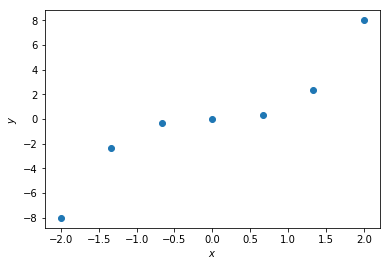

In [2]:
X = np.linspace(-2, 2, 7)
y = X ** 3
plt.scatter(X, y)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$');

Проделаем несколько шагов в построении дерева решений. Исходя из соображений симметрии, выберем пороги для разбиения равными соответственно 0, 1.5 и -1.5. Напомним, что в случае задачи восстановления регрессии листовая вершина выдает среднее значение ответа по всем объектам обучающей выборки, попавшим в эту вершину.

Итак, начнём. Дерево глубины 0 состоит из одного корня, который содержит всю обучающую выборку. Как будут выглядеть предсказания данного дерева для $x \in [-2, 2]$? Постройте соответствующий график. Тут без `sklearn` – разбираемся просто с ручкой, бумажкой и Python, если надо.

In [3]:
depth_0 = np.mean(y)
print(depth_0)

-2.5376526277146434e-16


Произведем первое разбиение выборки по предикату $[x < 0]$. Получим дерево глубины 1 с двумя листьями. Постройте аналогичный график предсказаний для этого дерева.

In [4]:
depth_1= np.array([np.mean(y[0:3]), np.mean(y[3:])])
print(depth_1)

[-3.55555556  2.66666667]


In [5]:
depth_1_list = list()
for i in range(len(X)):
    if i <3:
        depth_1_list.append(depth_1[0])
    else:
        depth_1_list.append(depth_1[1])


In [6]:
depth_1_list

[-3.5555555555555554,
 -3.5555555555555554,
 -3.5555555555555554,
 2.666666666666666,
 2.666666666666666,
 2.666666666666666,
 2.666666666666666]

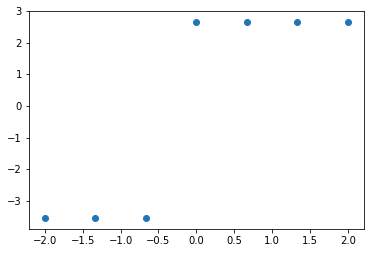

In [7]:
plt.scatter(X, depth_1_list )

В алгоритме построения дерева решений признак и значение порога, по которым происходит разбиение выборки, выбираются исходя из некоторого критерия. Для регрессии обычно используется дисперсионный критерий:
$$Q(X, j, t) = D(X) - \dfrac{|X_l|}{|X|} D(X_l) - \dfrac{|X_r|}{|X|} D(X_r),$$
где $X$ – выборка, находящаяся в текущей вершине, $X_l$ и $X_r$ – разбиение выборки $X$ на две части по предикату $[x_j < t]$ (то есть по $j$-ому признаку и порогу $t$), $|X|$, $|X_l|$, $|X_r|$ - размеры соответствующих выборок, а $D(X)$ – дисперсия ответов на выборке $X$:
$$D(X) = \dfrac{1}{|X|} \sum_{x_j \in X}(y_j – \dfrac{1}{|X|}\sum_{x_i \in X}y_i)^2,$$
где $y_i = y(x_i)$ – ответ на объекте $x_i$. При каждом разбиении вершины выбираются признак $j$ и значение порога $t$, максимизирующие значение функционала $Q(X, j, t)$.

В нашем случае признак всего один, поэтому $Q$ зависит только от значения порога $t$ (и ответов выборки в данной вершине). 

Постройте график функции $Q(X, t)$ в корне в зависимости от значения порога $t$ на отрезке $[-1.9, 1.9]$.

In [8]:
def regression_var_criterion(X, y, t):
    return np.std(y) - (len(y[X <= t])/len(X)) * np.std(y[X <= t]) - (len(y[X > t])/len(X)) * np.std(y[X > t])

In [9]:
ts = np.linspace(-1.9, 1.9, 10)
criteria = list()
for t in ts:
    criteria.append(regression_var_criterion(X,y,t))
    
    

In [10]:
np.std(y) - len(y[X <= -1.5])/len(X) * np.std(y[X <= -1.5]) - (len(y[X > -1.5])/len(X)) * np.std(y[X > -1.5])

1.6470590199588258

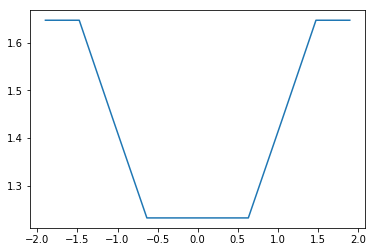

In [11]:
plt.plot(ts,criteria)

**<font color='red'>Вопрос 1.</font> Оптимально ли с точки зрения дисперсионного критерия выбранное нами значение порога $t = 0$?**
- <font color = 'green'>Да </font>
- Нет

Теперь произведем разбиение в каждой из листовых вершин. В левой (соответствующей ветви $x < 0$) – по предикату $[x < -1.5]$, а в правой (соответствующей ветви $x \geqslant 0$) – по предикату $[x < 1.5]$. Получится дерево глубины 2 с 7 вершинами и 4 листьями. Постройте график предсказаний этого дерева для $x \in [-2, 2]$.

In [12]:
y[X<-1.5]

array([-8.])

In [13]:
np.mean(y[(X>=-1.5) & (X < 0)])

-1.3333333333333337

In [14]:
np.mean(y[(X>=0) & (X < 1.5)])

0.8888888888888884

In [15]:
np.mean(y[X>=1.5])

8.0

In [16]:
X

array([-2.        , -1.33333333, -0.66666667,  0.        ,  0.66666667,
        1.33333333,  2.        ])

In [17]:
XX = [-2,-1.5,0,1.5,2]
predictions = [-8,-8,-1.333,0.888,8 ]

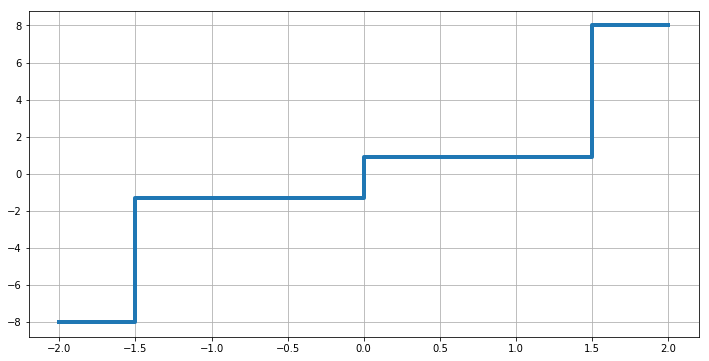

In [18]:
plt.figure(figsize=(12,6))
plt.grid()
plt.step(XX, predictions, lw=4)

**<font color='red'>Вопрос 2.</font> Из какого числа отрезков состоит график (необходимо считать как горизонтальные, так и вертикальные прямые), изображающий предсказания построенного дерева на отрезке [-2, 2]?**
- 5
- 6
- <font color = 'green'>7 </font>
- 8

## 2. Построение дерева решений для прогноза сердечно-сосудистых заболеваний
Считаем в `DataFrame` знакомый нам набор данных по сердечно-сосудистым заболеваниям. 

In [19]:
df = pd.read_csv('../../data/mlbootcamp5_train.csv', 
                 index_col='id', sep=';')

In [20]:
df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,17474,1,156,56.0,100,60,1,1,0,0,0,0


Сделайте небольшие преобразования признаков: постройте признак "возраст в годах" (полных лет), а также постройте по 3 бинарных признака на основе `cholesterol` и `gluc`, где они, соответственно, равны 1, 2 или 3. Эта техника называется dummy-кодированием или One Hot Encoding (OHE), удобней всего в данном случае использовать `pandas.get_dummmies`. Исходные признаки `cholesterol` и `gluc` после кодирования использовать не нужно.

In [21]:
df_with_dummies = pd.get_dummies(df, columns= ['cholesterol','gluc'], prefix=['chol', 'gluc']) 

In [22]:
df_with_dummies.head()

,age,gender,height,weight,ap_hi,ap_lo,smoke,alco,active,cardio,chol_1,chol_2,chol_3,gluc_1,gluc_2,gluc_3
id,,,,,,,,,,,,,,,,
0,18393,2,168,62.0,110,80,0,0,1,0,1,0,0,1,0,0
1,20228,1,156,85.0,140,90,0,0,1,1,0,0,1,1,0,0
2,18857,1,165,64.0,130,70,0,0,0,1,0,0,1,1,0,0
3,17623,2,169,82.0,150,100,0,0,1,1,1,0,0,1,0,0
4,17474,1,156,56.0,100,60,0,0,0,0,1,0,0,1,0,0


In [23]:
df_with_dummies['age_years'] = (df_with_dummies['age'] // 365.25).astype(int)

In [24]:
df_with_dummies = df_with_dummies.drop(['age'], axis=1)

In [25]:
df_with_dummies.head()

,gender,height,weight,ap_hi,ap_lo,smoke,alco,active,cardio,chol_1,chol_2,chol_3,gluc_1,gluc_2,gluc_3,age_years
id,,,,,,,,,,,,,,,,
0,2,168,62.0,110,80,0,0,1,0,1,0,0,1,0,0,50
1,1,156,85.0,140,90,0,0,1,1,0,0,1,1,0,0,55
2,1,165,64.0,130,70,0,0,0,1,0,0,1,1,0,0,51
3,2,169,82.0,150,100,0,0,1,1,1,0,0,1,0,0,48
4,1,156,56.0,100,60,0,0,0,0,1,0,0,1,0,0,47


In [26]:
from sklearn.model_selection import train_test_split

In [27]:
y = df_with_dummies['cardio']

In [28]:
df_with_dummies_without_labels = df_with_dummies.drop(['cardio'], axis=1)

In [29]:
X = df_with_dummies_without_labels

In [30]:
X.head()

,gender,height,weight,ap_hi,ap_lo,smoke,alco,active,chol_1,chol_2,chol_3,gluc_1,gluc_2,gluc_3,age_years
id,,,,,,,,,,,,,,,
0,2,168,62.0,110,80,0,0,1,1,0,0,1,0,0,50
1,1,156,85.0,140,90,0,0,1,0,0,1,1,0,0,55
2,1,165,64.0,130,70,0,0,0,0,0,1,1,0,0,51
3,2,169,82.0,150,100,0,0,1,1,0,0,1,0,0,48
4,1,156,56.0,100,60,0,0,0,1,0,0,1,0,0,47


Разбейте выборку на обучающую и отложенную (holdout) части в пропорции 7/3. Для этого используйте метод `sklearn.model_selection.train_test_split`, зафиксируйте у него `random_state`=17.

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=17)

Обучите на выборке `(X_train, y_train)` дерево решений с ограничением на максимальную глубину в 3. Зафиксируйте у дерева `random_state=17`. Визуализируйте дерево с помошью `sklearn.tree.export_graphviz`, `dot` и `pydot`. Пример дан в [статье](https://habrahabr.ru/company/ods/blog/322534/) под спойлером "Код для отрисовки дерева". Названия файлов писать без кавычек, для того чтобы работало в jupyter notebook. Обратите внимание, что команды в Jupyter notebook, начинающиеся с восклицательного знака – это терминальные команды (которые мы обычно запускаем в терминале/командной строке).

In [32]:
from sklearn.tree import DecisionTreeClassifier

In [33]:
model = DecisionTreeClassifier(max_depth=3, random_state=17)

In [34]:
model.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=17,
            splitter='best')

In [35]:
# используем .dot формат для визуализации дерева
from sklearn.tree import export_graphviz
export_graphviz(model, feature_names=df_with_dummies_without_labels.columns, 
out_file='small_tree.dot', filled=True)
# для этого понадобится библиотека pydot (pip install pydot)
!dot -Tpng 'small_tree.dot' -o 'small_tree.png'

**<font color='red'>Вопрос 3.</font> Какие 3 признака задействуются при прогнозе в построенном дереве решений? (то есть эти три признака "можно найти в дереве")**
- weight, height, gluc=3
- smoke, age, gluc=3
- age, weight, chol=3
- <font color = 'green'>age, ap_hi, chol=3</font>

Сделайте с помощью обученного дерева прогноз для отложенной выборки `(X_test, y_test)`. Посчитайте долю верных ответов (accuracy).

In [36]:
predictions = model.predict(X_test)

In [37]:
from sklearn.metrics import accuracy_score

In [38]:
acc1 = accuracy_score(predictions, y_test)

In [39]:
print(acc1)

0.7212857142857143


Теперь на кросс-валидации по выборке  `(X_train, y_train)`  настройте глубину дерева, чтобы повысить качество модели. Используйте GridSearchCV, 5-кратную кросс-валидацию. Зафиксируйте у дерева `random_state`=17. Перебирайте параметр `max_depth` от 2 до 10. 

In [40]:
from sklearn.model_selection import GridSearchCV
tree_params = {'max_depth': list(range(2, 11))}
tree_grid = GridSearchCV(DecisionTreeClassifier(random_state=17), tree_params, cv=5)

In [41]:
tree_grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=17,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [42]:
tree_grid.cv_results_['mean_test_score']

array([0.7155102 , 0.72771429, 0.73069388, 0.73110204, 0.73220408,
       0.72995918, 0.73036735, 0.72795918, 0.72646939])

Нарисуйте график того, как меняется средняя доля верных ответов на кросс-валидации в зависимости от значения `max_depth`.

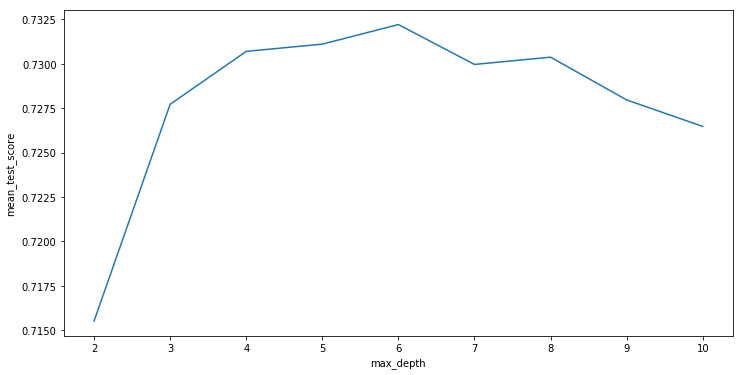

In [43]:
plt.figure(figsize=(12,6))
plt.xlabel('max_depth')
plt.ylabel('mean_test_score')
plt.plot(tree_params['max_depth'], tree_grid.cv_results_['mean_test_score'])

Выведите лучшее значение `max_depth`, то есть такое, при котором среднее значение метрики качества на кросс-валидации максимально. Посчитайте также, какова теперь доля верных ответов на отложенной выборке. Все это можно сделать с помощью обученного экземпляра класса `GridSearchCV`.

In [44]:
tree_grid.best_params_

{'max_depth': 6}

In [45]:
predictions_tree_grid = tree_grid.predict(X_test)

In [46]:
acc2 = accuracy_score(predictions_tree_grid, y_test)

In [47]:
print(acc2)

0.7256190476190476


In [48]:
print(100*(acc2 - acc1)/acc1)

0.6007790321515766


**<font color='red'>Вопрос 4.</font> Имеется ли на кривой валидации по максимальной глубине дерева пик `accuracy`, если перебирать `max_depth` от 2 до 10? Повысила ли настройка глубины дерева качество классификации (accuracy) более чем на 1% на отложенной выборке (надо посмотреть на выражение (acc2 - acc1) / acc1 * 100%, где acc1 и acc2 – доли верных ответов на отложенной выборке до и после настройки max_depth соответственно)?**
- да, да
- <font color = 'green'>да, нет </font>
- нет, да
- нет, нет

Обратимся опять (как и в 1 домашке) к картинке, демонстрирующей шкалу SCORE для расчёта риска смерти от сердечно-сосудистого заболевания в ближайшие 10 лет.
<img src='../../img/SCORE2007.png' width=70%>

Создайте бинарные признаки, примерно соответствующие этой картинке:
- $age \in [45,50), \ldots age \in [60,65) $ (4 признака)
- верхнее артериальное давление: $ap\_hi \in [120,140), ap\_hi \in [140,160), ap\_hi \in [160,180),$ (3 признака)

Если значение возраста или артериального давления не попадает ни в один из интервалов, то все бинарные признаки будут равны нулю. Далее будем строить дерево решений с этим признаками, а также с признаками ``smoke``, ``cholesterol``  и ``gender``. Из признака ``cholesterol`` надо сделать 3 бинарных, соотв-х уникальным значениям признака ( ``cholesterol``=1,  ``cholesterol``=2 и  ``cholesterol``=3), эта техника называется dummy-кодированием или One Hot Encoding (OHE). Признак ``gender`` надо перекодировать: значения 1 и 2 отобразить на 0 и 1. Признак лучше переименовать в ``male`` (0 – женщина, 1 – мужчина). В общем случае кодирование значений делает ``sklearn.preprocessing.LabelEncoder``, но в данном случае легко обойтись и без него.

Итак, дерево решений строится на 12 бинарных признаках (исходные признаки не берем).

Постройте дерево решений с ограничением на максимальную глубину = 3 и обучите его на всей исходной обучающей выборке. Используйте `DecisionTreeClassifier`, на всякий случай зафикисровав `random_state=17`, остальные аргументы (помимо `max_depth` и `random_state`) оставьте по умолчанию. 

**<font color='red'>Вопрос 5.</font> Какой бинарный признак из 12 перечисленных оказался самым важным для обнаружения ССЗ, то есть поместился в вершину построенного дерева решений?**
- Верхнее артериальное давление от 160 до 180 (мм рт.ст.)
- Пол мужской / женский
- <font color = 'green'>Верхнее артериальное давление от 140 до 160 (мм рт.ст.) </font>
- Возраст от 50 до 55 (лет)
- Курит / не курит
- Возраст от 60 до 65 (лет)

In [49]:
df_with_dummies_without_labels['age_1'] = df_with_dummies_without_labels['age_years'].apply(lambda x: 1 if ((x >= 45) & (x < 50)) else 0)
df_with_dummies_without_labels['age_2'] = df_with_dummies_without_labels['age_years'].apply(lambda x: 1 if ((x >= 50) & (x < 55)) else 0)
df_with_dummies_without_labels['age_3'] = df_with_dummies_without_labels['age_years'].apply(lambda x: 1 if ((x >= 55) & (x < 60)) else 0)
df_with_dummies_without_labels['age_4'] = df_with_dummies_without_labels['age_years'].apply(lambda x: 1 if ((x >= 60) & (x < 65)) else 0)
df_with_dummies_without_labels['ap_hi_1'] = df_with_dummies_without_labels['ap_hi'].apply(lambda x: 1 if ((x >= 120) & (x < 140)) else 0)
df_with_dummies_without_labels['ap_hi_2'] = df_with_dummies_without_labels['ap_hi'].apply(lambda x: 1 if ((x >= 140) & (x < 160)) else 0)
df_with_dummies_without_labels['ap_hi_3'] = df_with_dummies_without_labels['ap_hi'].apply(lambda x: 1 if ((x >= 160) & (x < 180)) else 0)
df_with_dummies_without_labels['male'] = df_with_dummies_without_labels['gender'].apply(lambda x: 1 if x ==2 else 0)

In [50]:
columns_to_drop = ['gender','height','weight','ap_hi','ap_lo','alco','active','age_years', 'gluc_1','gluc_2', 'gluc_3']

In [51]:
df_with_dummies_without_labels = df_with_dummies_without_labels.drop(columns=columns_to_drop)

In [52]:
X = df_with_dummies_without_labels

In [53]:
model = DecisionTreeClassifier(max_depth=3, random_state= 17)
model.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=17,
            splitter='best')

In [54]:
export_graphviz(model, feature_names=df_with_dummies_without_labels.columns, 
out_file='small_tree_1.dot', filled=True)
# для этого понадобится библиотека pydot (pip install pydot)
!dot -Tpng 'small_tree_1.dot' -o 'small_tree_1.png'